### Imports

In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
import warnings
import copy

warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('ggplot')

### Configs

Será utilizados um dicionário para categorizar os estados, casa estado receberá um número condizente com seu PIB, sendo os maiores números os maiores PIBs e os menores números os menores PIBs.

Fonte: https://www.ibge.gov.br/explica/pib.php

In [2]:
# Dicionário para o enconding estadual
uf_dict = {'SP':28, 'RJ':27, 'MG':26, 'RS':25, 'PR':24, 'SC':23, 'DF':22, 'BA':21, 'GO':20, 'PE':19,
           'ES':18, 'PA':17, 'CE':16, 'MT':15, 'AM':14, 'MA':13, 'MS':12, 'RN':11, 'PB':10, 'AL': 9,
           'RO': 8, 'SE': 7, 'PI': 6, 'TO': 5, 'AP': 4, 'AC': 3, 'RR': 2, 'DE':1}

# file paths
pre_model_path = '..\data\dados_pre_model.csv'
model_file_path = r'..\model\finalized_model.sav'
after_model_path = '..\data\dados_after_model.csv'

### Modelagem, Avaliação e Otimização

In [19]:
df = pd.read_csv(pre_model_path); df.head()

,Município,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000","Renda per Capita, 2000","Índice de Gini, 2000",...,"Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 1991","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 1991","População de 65 anos ou mais de idade, 2000","População total, 1991","População total, 2000","População urbana, 2000","População rural, 2000",Estado
0,Abadia de Goiás (GO),136.9,36.3,21.414308,67.58,27.70,2.85,15.64,205.27,0.53,...,4.87,1872,2433,121,227,4227,4971,3096,1875,GO
1,Abadia dos Dourados (MG),897.4,7.2,390.876513,72.92,20.51,2.54,14.48,196.36,0.52,...,4.36,3308,3781,354,459,6492,6446,3927,2519,MG
2,Abadiânia (GO),1047.7,10.9,78.641435,69.59,22.36,2.77,21.81,168.31,0.56,...,4.24,4241,5918,446,686,9402,11452,7206,4246,GO
3,Abaetetuba (PA),1613.9,73.8,51.184552,70.77,25.61,3.15,24.85,102.14,0.59,...,4.28,33554,44897,3792,4688,99989,119152,70843,48309,PA
4,Abaeté (MG),1822.4,12.3,172.311549,72.50,21.59,2.41,15.56,253.68,0.58,...,4.78,10163,12406,1084,1595,20689,22360,19022,3338,MG


In [20]:
# Transformando a coluna estado em dado categórico e removendo a coluna nome dos Municípios, uma vez que não será útil para modelagem
dados=copy.deepcopy(df)
dados.drop('Município',axis=1, inplace=True)
dados['Estado'] = dados['Estado'].apply(lambda x: uf_dict[x])

# Utilizando os dados com melhores distribuições segundo o notebook 01_analise_dos_dados_pre_agrupamento:

dados = dados[['Distância à capital (km)',
               'Esperança de vida ao nascer, 2000',
               'Mortalidade até um ano de idade, 2000',
               'Taxa de fecundidade total, 2000',
               'Percentual de pessoas de 25 anos ou mais analfabetas, 2000',
               'Renda per Capita, 2000', 'Índice de Gini, 2000',
               'Intensidade da indigência, 2000', 'Intensidade da pobreza, 2000',
               'Índice de Desenvolvimento Humano Municipal, 2000',
               'Taxa bruta de freqüência à escola, 2000',
               'Taxa de alfabetização, 2000',
               'Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000']]

In [21]:
# Modelagem
pca = PCA(n_components=2)

dados = dados.values

scaler = Normalizer().fit(dados)
dados = scaler.transform(dados)
dados = pca.fit_transform(dados)


exp_var_pca = pca.explained_variance_ratio_.cumsum()
exp_var_pca[1]

0.9511528691944019

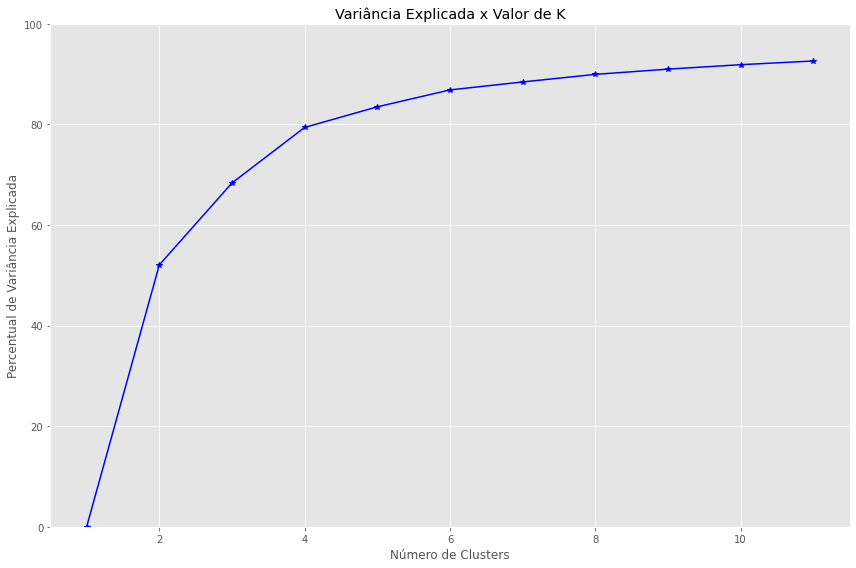

In [22]:
# Definindo o tamanho dos gráficos
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)

# Determinando um range de K
k_range = range(1,12)

# Aplicando o modelo K-Means para cada valor de K (esta célula pode levar bastante tempo para ser executada)
k_means_var = [KMeans(n_clusters = k).fit(dados) for k in k_range]

# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(dados, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Soma total dos quadrados
soma_total = sum(pdist(dados)**2)/dados.shape[0]

# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

# Plotando o resultado
plt.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax = plt.gca()
ax.set_ylim([0,100])
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Percentual de Variância Explicada')
plt.title('Variância Explicada x Valor de K')

fig.tight_layout()
plt.show()

Esse gráfico nos da uma visão geral dos valores otimizados de K a serem utilizados, nitidamente os valores de K abaixo de 6 não conseguem explicar a maioria da variância entre os dados.

A partir do exposto acima, será feita uma análise para verificar qual o valor ótimo de clusters para que não ocorra sobreposição de grupos.

In [24]:
# Criando um modelo com K = 3 a 6

modelos = dict()

# Treinando os Modelos
for i in range(3,10):
    m = KMeans(n_clusters = i)
    modelos.update({'modelo_k'+str(i) : m.fit(dados)})

# Print dos Resultados
for key in modelos.keys():
    labels = modelos[key].labels_
    print(key,": ",silhouette_score(dados, labels, metric = 'euclidean'))

modelo_k3 :  0.4679462902747635
modelo_k4 :  0.4478298228182189
modelo_k5 :  0.43258446706884374
modelo_k6 :  0.4209535539257071
modelo_k7 :  0.3907453394230738
modelo_k8 :  0.3837280885209587
modelo_k9 :  0.38599190791975657


O silhouette score é muito parecido para todos os números de clusters diminui drásticamente depois de K=6, vamos plotar alguns gráficos para verificar a disposição desses grupos de forma visual

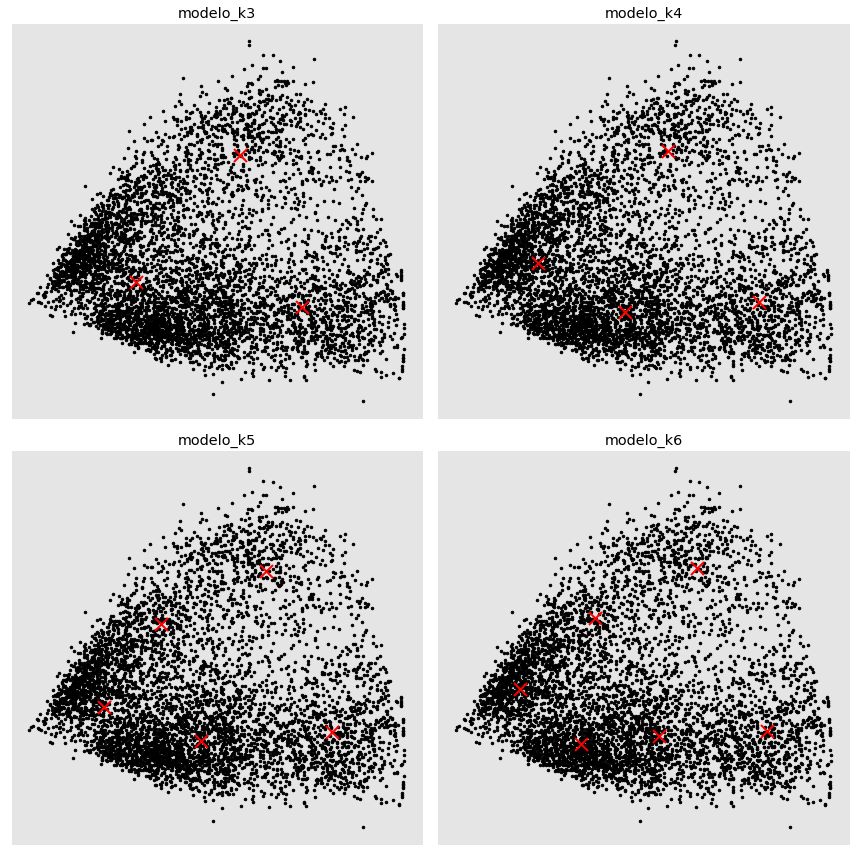

In [29]:
# Confiugurando tamanho da figura
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

    
# Plotando Centróides
for i, model_k in enumerate(['modelo_k3', 'modelo_k4', 'modelo_k5', 'modelo_k6']):
    
    modelo = modelos[model_k]
    
    plt.subplot(2,2, i+1)
    plt.plot(dados[:, 0], dados[:, 1], 'k.', markersize = 5)
    centroids = modelo.cluster_centers_
    inert = modelo.inertia_
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 2, color = 'r', zorder = 8)
    plt.title(model_k)
    plt.xticks(())
    plt.yticks(())


fig.tight_layout()
plt.show()

Vamos colorir os pontos de acordo com o grupo a qual eles pertencem

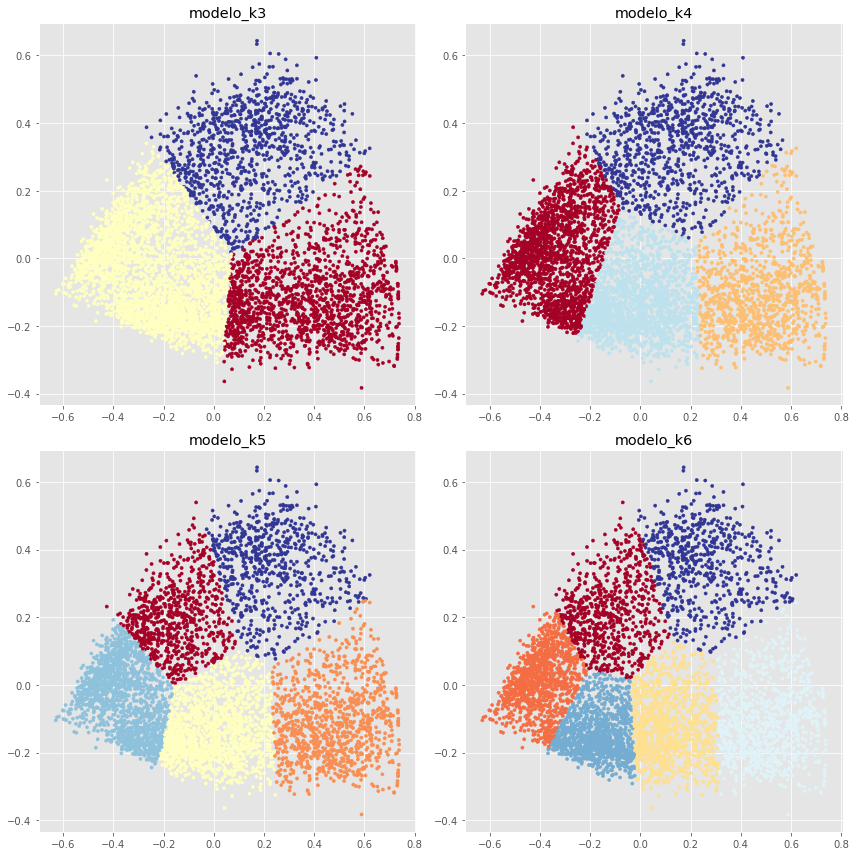

In [30]:
# Confiugurando tamanho da figura
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

    
# Plotando Centróides
for i, model_k in enumerate(['modelo_k3', 'modelo_k4', 'modelo_k5', 'modelo_k6']):
    
    modelo = modelos[model_k]
    label = modelo.labels_
    
    plt.subplot(2,2, i+1)
    plt.scatter(dados[:, 0], dados[:, 1], c=label, s=10, cmap='RdYlBu')
    plt.title(model_k)


fig.tight_layout()
plt.show()

In [31]:
df['Grupo'] = model.labels_
df['Grupo'] = df['Grupo'].apply(lambda x: 'Grupo '+str(x+1))
df.head()

,Município,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000","Renda per Capita, 2000","Índice de Gini, 2000",...,"População de 25 anos ou mais de idade, 1991","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 1991","População de 65 anos ou mais de idade, 2000","População total, 1991","População total, 2000","População urbana, 2000","População rural, 2000",Estado,Grupo
0,Abadia de Goiás (GO),136.9,36.3,21.414308,67.58,27.70,2.85,15.64,205.27,0.53,...,1872,2433,121,227,4227,4971,3096,1875,GO,Grupo 2
1,Abadia dos Dourados (MG),897.4,7.2,390.876513,72.92,20.51,2.54,14.48,196.36,0.52,...,3308,3781,354,459,6492,6446,3927,2519,MG,Grupo 6
2,Abadiânia (GO),1047.7,10.9,78.641435,69.59,22.36,2.77,21.81,168.31,0.56,...,4241,5918,446,686,9402,11452,7206,4246,GO,Grupo 2
3,Abaetetuba (PA),1613.9,73.8,51.184552,70.77,25.61,3.15,24.85,102.14,0.59,...,33554,44897,3792,4688,99989,119152,70843,48309,PA,Grupo 4
4,Abaeté (MG),1822.4,12.3,172.311549,72.50,21.59,2.41,15.56,253.68,0.58,...,10163,12406,1084,1595,20689,22360,19022,3338,MG,Grupo 7


In [32]:
df_teste = copy.deepcopy(df.drop('Município', axis=1))
df_teste['Estado'] = df_teste['Estado'].apply(lambda x: uf_dict[x])
df_teste.drop('Grupo',axis=1, inplace=True)
df_teste_values = PCA(n_components=2).fit_transform(df_teste.values)

In [33]:
df_teste['Grupo'] = model.predict(df_teste_values)

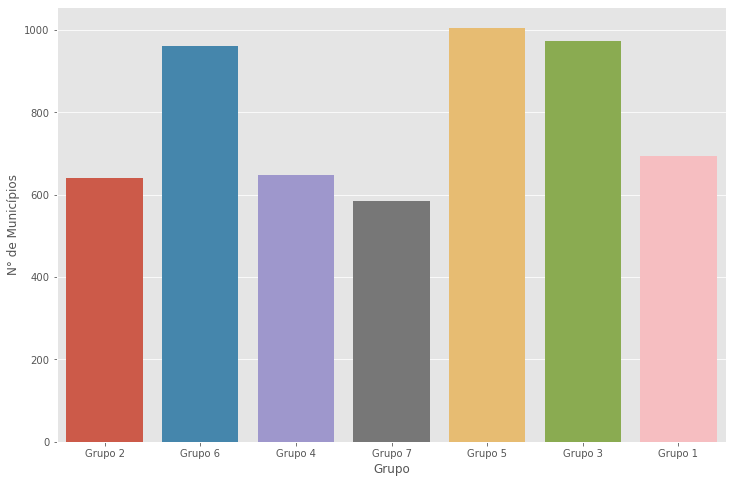

In [34]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)

sns.countplot(x=df['Grupo'])

plt.ylabel('N° de Municípios')
plt.show()

In [35]:
df['Grupo'].value_counts()

Grupo 5    1006
Grupo 3     974
Grupo 6     961
Grupo 1     694
Grupo 4     647
Grupo 2     640
Grupo 7     585
Name: Grupo, dtype: int64

### Salvando o modelo e o DataFrame Resultante

In [ ]:
joblib.dump(model, model_file_path)
df.to_csv(after_model_path, index=False)